<a id="3"></a>
## **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#e55b17;font-size:120%;font-family:Verdana;"><center><span> Import Libraries </span></center></div>**

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

<a id="3"></a>
## **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#e55b17;font-size:120%;font-family:Verdana;"><center><span>1. Spark Session</span></center></div>**

In [ ]:
spark = SparkSession.builder.appName("ShipmentModePrediction").getOrCreate()

<a id="3"></a>
## **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#e55b17;font-size:120%;font-family:Verdana;"><center><span>2. Data Reading</span></center></div>**

In [2]:
df = spark.read.csv("SCMS_Delivery_History_Dataset.csv", header=True, inferSchema=True)
df.printSchema()
df.show(5)

root
 |-- ID: integer (nullable = true)
 |-- Project Code: string (nullable = true)
 |-- PQ #: string (nullable = true)
 |-- PO / SO #: string (nullable = true)
 |-- ASN/DN #: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Managed By: string (nullable = true)
 |-- Fulfill Via: string (nullable = true)
 |-- Vendor INCO Term: string (nullable = true)
 |-- Shipment Mode: string (nullable = true)
 |-- PQ First Sent to Client Date: string (nullable = true)
 |-- PO Sent to Vendor Date: string (nullable = true)
 |-- Scheduled Delivery Date: string (nullable = true)
 |-- Delivered to Client Date: string (nullable = true)
 |-- Delivery Recorded Date: string (nullable = true)
 |-- Product Group: string (nullable = true)
 |-- Sub Classification: string (nullable = true)
 |-- Vendor: string (nullable = true)
 |-- Item Description: string (nullable = true)
 |-- Molecule/Test Type: string (nullable = true)
 |-- Brand: string (nullable = true)
 |-- Dosage: string (nullable = tru

<a id="3"></a>
## **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#e55b17;font-size:120%;font-family:Verdana;"><center><span>3. Exploratory Data Analysis</span></center></div>**

In [3]:
# Initial Data Exploration
df.describe().show()
df.select('Shipment Mode').groupBy('Shipment Mode').count().show()
df.select([col(c).isNull().alias(c) for c in df.columns]).show(1)

+-------+-----------------+------------+--------------+----------+---------+-----------+--------------------+-----------+----------------+-------------+----------------------------+----------------------+-----------------------+------------------------+----------------------+-------------+------------------+--------------------+--------------------+------------------+------+--------+--------------------+--------------------------+------------------+------------------+------------------+------------------+--------------------+----------------------+--------------------+--------------------+-------------------------+
|summary|               ID|Project Code|          PQ #| PO / SO #| ASN/DN #|    Country|          Managed By|Fulfill Via|Vendor INCO Term|Shipment Mode|PQ First Sent to Client Date|PO Sent to Vendor Date|Scheduled Delivery Date|Delivered to Client Date|Delivery Recorded Date|Product Group|Sub Classification|              Vendor|    Item Description|Molecule/Test Type| Brand|

<a id="3"></a>
## **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#e55b17;font-size:120%;font-family:Verdana;"><center><span>4. Data Preprocessing</span></center></div>**

In [4]:
# For simplicity, fill missing numerics with 0, strings with "Unknown"
for field in df.schema.fields:
    if str(field.dataType) in ["DoubleType", "IntegerType"]:
        df = df.na.fill({field.name: 0})
    else:
        df = df.na.fill({field.name: "Unknown"})


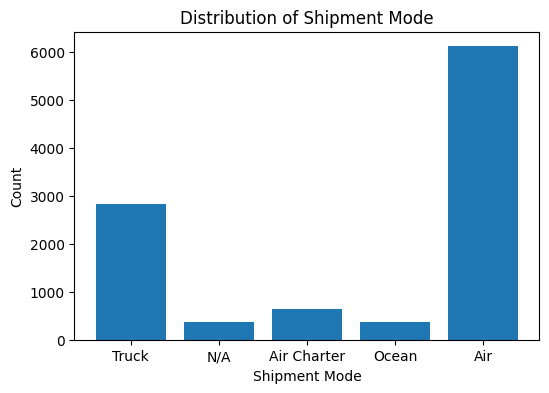

In [5]:
# shipment distribution of values
pd_data = df.select('Shipment Mode').groupBy('Shipment Mode').count().toPandas()
plt.figure(figsize=(6,4))
plt.bar(pd_data['Shipment Mode'], pd_data['count'])
plt.title("Distribution of Shipment Mode")
plt.xlabel("Shipment Mode")
plt.ylabel("Count")
plt.show()


In [6]:
ignore_cols = [
    'ID', 'PQ #', 'PO / SO #', 'ASN/DN #', 'Item Description',
    'PQ First Sent to Client Date', 'PO Sent to Vendor Date',
    'Scheduled Delivery Date', 'Delivered to Client Date', 'Delivery Recorded Date',
    'Project Code', 'Country', 'Managed By', 'Fulfill Via', 'Vendor INCO Term',
    'Product Group', 'Sub Classification', 'Vendor', 'Molecule/Test Type',
    'Brand', 'Dosage', 'Dosage Form', 'Manufacturing Site', 'First Line Designation'
]

<a id="3"></a>
## **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#e55b17;font-size:120%;font-family:Verdana;"><center><span>5. Data Cleaning</span></center></div>**

In [7]:
df = df.filter(
    (col("Shipment Mode").isNotNull()) &
    (col("Shipment Mode") != "") &
    (col("Shipment Mode") != "N/A") &
    (col("Shipment Mode") != "NA")
)

<a id="3"></a>
## **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#e55b17;font-size:120%;font-family:Verdana;"><center><span> 6. Feature Engineering</span></center></div>**

In [8]:
# Encoding target column (Means assigning labels to target column value)
# like that (0 --> Air, 1 --> Truck, 2 --> Air Charter, 3 --> Ocean)
# Note : 
# In Supply Chain Contex difference between Air and Air Charter:
# Air: Standard, shared service. Scheduled flights, generally lower cost than charter.
# Air Charter: Customized, private service. On-demand, premium cost for urgent or special shipments.

target_indexer = StringIndexer(inputCol="Shipment Mode", outputCol="ShipmentMode_index")
target_indexer_model = target_indexer.fit(df)
df = target_indexer_model.transform(df)

In [9]:
# Feature Indexing for Categorical Columns
feature_cols = [c for c in df.columns if c not in ignore_cols]
final_features = []
for c in feature_cols:
    if str(df.schema[c].dataType) == "StringType":
        indexer = StringIndexer(inputCol=c, outputCol=c+"_index", handleInvalid="keep")
        df = indexer.fit(df).transform(df)
        final_features.append(c+"_index")
    else:
        final_features.append(c)

In [10]:
# Corner case casting only that column if the column is in your final_features
for c in ["Weight (Kilograms)", "Freight Cost (USD)"]:
    if c in final_features:
        df = df.withColumn(c, df[c].cast("double"))

In [11]:
# dropping NA values because we can't fill target column to be mean or median or mode
df_clean = df.dropna(subset=final_features + ["ShipmentMode_index"])

In [12]:
# this step will make all the feature_cols column into one column features for Machine Learning model
assembler = VectorAssembler(inputCols=final_features, outputCol="features")
df_clean = assembler.transform(df_clean)

<a id="3"></a>
## **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#e55b17;font-size:120%;font-family:Verdana;"><center><span>7. Train-Test Split</span></center></div>**

In [13]:
train_data, test_data = df_clean.randomSplit([0.8, 0.2], seed=42)

<a id="3"></a>
## **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#e55b17;font-size:120%;font-family:Verdana;"><center><span>8. Model Building</span></center></div>**

<a id="3"></a>
#### **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#e55b17;font-size:120%;font-family:Verdana;"><center><span>Random Forest Classifier</span></center></div>**

In [14]:
rf = RandomForestClassifier(labelCol="ShipmentMode_index", featuresCol="features")
rf_model = rf.fit(train_data)
rf_preds = rf_model.transform(test_data)

<a id="3"></a>
#### **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#e55b17;font-size:120%;font-family:Verdana;"><center><span>Evaluation & Predictions</span></center></div>**

In [15]:
evaluator = MulticlassClassificationEvaluator(labelCol="ShipmentMode_index", predictionCol="prediction", metricName="accuracy")
rf_accuracy = evaluator.evaluate(rf_preds)
print(f"Random Forest Accuracy: {rf_accuracy:.3f}")

rf_preds.groupBy("ShipmentMode_index", "prediction").count().show()

Random Forest Accuracy: 0.726
+------------------+----------+-----+
|ShipmentMode_index|prediction|count|
+------------------+----------+-----+
|               2.0|       0.0|   64|
|               1.0|       1.0|   69|
|               0.0|       1.0|   19|
|               1.0|       0.0|  159|
|               2.0|       2.0|    1|
|               3.0|       1.0|   24|
|               2.0|       1.0|   21|
|               0.0|       0.0|  737|
|               3.0|       3.0|    6|
|               0.0|       3.0|    1|
|               3.0|       0.0|   19|
+------------------+----------+-----+



In [16]:
# Convert index back to string
labels = target_indexer_model.labels

def idx2label(idx):
    return labels[int(idx)] if idx is not None else None

idx2label_udf = udf(idx2label, StringType())

rf_preds = rf_preds.withColumn("Actual_Label", idx2label_udf("ShipmentMode_index"))
rf_preds = rf_preds.withColumn("Predicted_Label", idx2label_udf("prediction"))

rf_preds.groupBy(
    "ShipmentMode_index", "Actual_Label",
    "prediction", "Predicted_Label"
).count().show(truncate=False)

+------------------+------------+----------+---------------+-----+
|ShipmentMode_index|Actual_Label|prediction|Predicted_Label|count|
+------------------+------------+----------+---------------+-----+
|0.0               |Air         |3.0       |Ocean          |1    |
|1.0               |Truck       |0.0       |Air            |159  |
|3.0               |Ocean       |1.0       |Truck          |24   |
|0.0               |Air         |0.0       |Air            |737  |
|1.0               |Truck       |1.0       |Truck          |69   |
|2.0               |Air Charter |2.0       |Air Charter    |1    |
|2.0               |Air Charter |0.0       |Air            |64   |
|3.0               |Ocean       |3.0       |Ocean          |6    |
|3.0               |Ocean       |0.0       |Air            |19   |
|2.0               |Air Charter |1.0       |Truck          |21   |
|0.0               |Air         |1.0       |Truck          |19   |
+------------------+------------+----------+---------------+--

<a id="3"></a>
#### **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#e55b17;font-size:120%;font-family:Verdana;"><center><span>Logistic Regression</span></center></div>**

In [17]:
lr = LogisticRegression(labelCol="ShipmentMode_index", featuresCol="features", maxIter=20)
lr_model = lr.fit(train_data)
lr_preds = lr_model.transform(test_data)

<a id="3"></a>
#### **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#e55b17;font-size:120%;font-family:Verdana;"><center><span>Evaluation & Predictions</span></center></div>**

In [18]:
lr_accuracy = evaluator.evaluate(lr_preds)
print(f"Logistic Regression Accuracy: {lr_accuracy:.3f}")

lr_preds.groupBy("ShipmentMode_index", "prediction").count().show()

Logistic Regression Accuracy: 0.725
+------------------+----------+-----+
|ShipmentMode_index|prediction|count|
+------------------+----------+-----+
|               2.0|       0.0|   70|
|               1.0|       1.0|   54|
|               0.0|       1.0|    8|
|               1.0|       0.0|  167|
|               2.0|       2.0|    2|
|               3.0|       1.0|   15|
|               2.0|       1.0|   14|
|               1.0|       2.0|    4|
|               0.0|       0.0|  746|
|               1.0|       3.0|    3|
|               0.0|       2.0|    3|
|               3.0|       3.0|   10|
|               3.0|       0.0|   24|
+------------------+----------+-----+



In [19]:
# Convert index back to string
labels = target_indexer_model.labels

def idx2label(idx):
    return labels[int(idx)] if idx is not None else None

idx2label_udf = udf(idx2label, StringType())

lr_preds = lr_preds.withColumn("Actual_Label", idx2label_udf("ShipmentMode_index"))
lr_preds = lr_preds.withColumn("Predicted_Label", idx2label_udf("prediction"))

lr_preds.groupBy(
    "ShipmentMode_index", "Actual_Label",
    "prediction", "Predicted_Label"
).count().show(truncate=False)

+------------------+------------+----------+---------------+-----+
|ShipmentMode_index|Actual_Label|prediction|Predicted_Label|count|
+------------------+------------+----------+---------------+-----+
|1.0               |Truck       |2.0       |Air Charter    |4    |
|0.0               |Air         |2.0       |Air Charter    |3    |
|1.0               |Truck       |0.0       |Air            |167  |
|3.0               |Ocean       |1.0       |Truck          |15   |
|0.0               |Air         |0.0       |Air            |746  |
|1.0               |Truck       |1.0       |Truck          |54   |
|2.0               |Air Charter |2.0       |Air Charter    |2    |
|2.0               |Air Charter |0.0       |Air            |70   |
|1.0               |Truck       |3.0       |Ocean          |3    |
|3.0               |Ocean       |3.0       |Ocean          |10   |
|3.0               |Ocean       |0.0       |Air            |24   |
|2.0               |Air Charter |1.0       |Truck          |14